<a href="https://colab.research.google.com/github/kocurvik/edu/blob/master/DOD/DOD_2019_DeepDream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Toto je upravená verzia originálneho notebooku:

### DeepDreaming with TensorFlow
### ___Alex Mordvintsev___
https://research.google.com/seedbank/seed/deepdream

### 1) Načítanie modelu neurónovej siete

Najprv je nutné stiahnuť si predtrénovaný model neurónovej siete [tu](https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip). Tento blok kódu to za nás urobí autoamicky a model tiež načíta.

In [0]:
!wget -nc --no-check-certificate https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip && unzip -n inception5h.zip
!wget -nc https://github.com/tensorflow/tensorflow/raw/master/tensorflow/examples/tutorials/deepdream/pilatus800.jpg
file_contents = open("pilatus800.jpg").read() 

from io import BytesIO
from IPython.display import clear_output, Image, display
import numpy as np
import PIL.Image
import tensorflow as tf
from __future__ import print_function

model_fn = 'tensorflow_inception_graph.pb'

# načítanie modelu do pamäte
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input')
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

def T(layer):
    '''Funkcia ktorá vráti vrstvu podľa názvu'''
    return graph.get_tensor_by_name("import/%s:0"%layer)

File ‘inception5h.zip’ already there; not retrieving.

Archive:  inception5h.zip
File ‘pilatus800.jpg’ already there; not retrieving.

Instructions for updating:
Use tf.gfile.GFile.


### Načítanie vlastného obrázku

### Tento krok môžete vynechať ak chcete pracovať s prednastaveným obrázkom 

In [0]:
from google.colab import files
uploaded = files.upload()

In [0]:

if type(uploaded) is not dict: uploaded = uploaded.files  ## Deal with filedit versions
file_contents = uploaded[uploaded.keys()[0]]

### 2) Načítanie obrázka do pamäte

Instructions for updating:
Colocations handled automatically by placer.


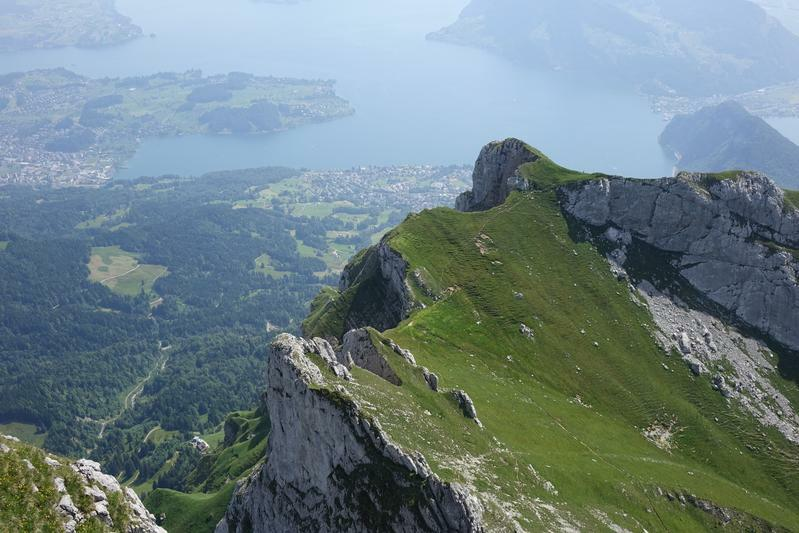

In [0]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
img0 = sess.run(tf.image.decode_image(file_contents))
showarray(img0)

### 3) Kód algoritmu DeepDream

In [0]:
# Tieto parametre určujú "silu" DeepDreamu
octave_n = 4
octave_scale = 1.4
iter_n = 10
strength = 200

# Funkcia na zmenu veľkosti obrázka
def resize(img, new_size):
    return sess.run(tf.image.resize_bilinear(img[np.newaxis,:], new_size))[0]

# Aplikujeme gradient (deriváciu) na časti obrázka
def calc_grad_tiled(img, t_grad, tile_size=256):
    '''V tejto časti je nutné vždy jednotlivé časti obrázka poposúvať, aby v
    ňom nevznikli hrany'''
    h, w = img.shape[:2]
    sx, sy = np.random.randint(tile_size, size=2)
    # Posúvanie robíme náhodne
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    # Teraz spočítame gradient
    grad = np.zeros_like(img)
    for y in range(0, max(h-tile_size//2, tile_size),tile_size):
        for x in range(0, max(w-tile_size//2, tile_size),tile_size):
            sub = img_shift[y:y+tile_size,x:x+tile_size]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+tile_size,x:x+tile_size] = g
    imggrad = np.roll(np.roll(grad, -sx, 1), -sy, 0)
    # Add the image gradient to the image and return the result
    return img + imggrad*(strength * 0.01 / (np.abs(imggrad).mean()+1e-7))

# Táto funkcia aplikuje DeepDream na rôznych škálach
def render_deepdream(t_obj, input_img, show_steps = True):
    # Vytvoríme jednotnú cenovú funkciu
    t_score = tf.reduce_mean(t_obj)
    # Potrebujeme gradient na časti obrázku
    t_grad = tf.gradients(t_score, t_input)[0]

    # Vytvoríme tzv. Laplacovskú pyramídu
    img = input_img
    octaves = []
    for i in range(octave_n-1):
        lo = resize(img, np.int32(np.float32(img.shape[:2])/octave_scale))
        octaves.append(img-resize(lo, img.shape[:2]))
        img = lo

    # Vytvoríme detaily na rôznych škálach
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for i in range(iter_n):
            img = calc_grad_tiled(img, t_grad)
        if show_steps:
            clear_output()
            showarray(img)
    return img

### 4) Spustenie algoritmu!

Môžete pomeniť nastavenia v predchádzajúcom kroku.

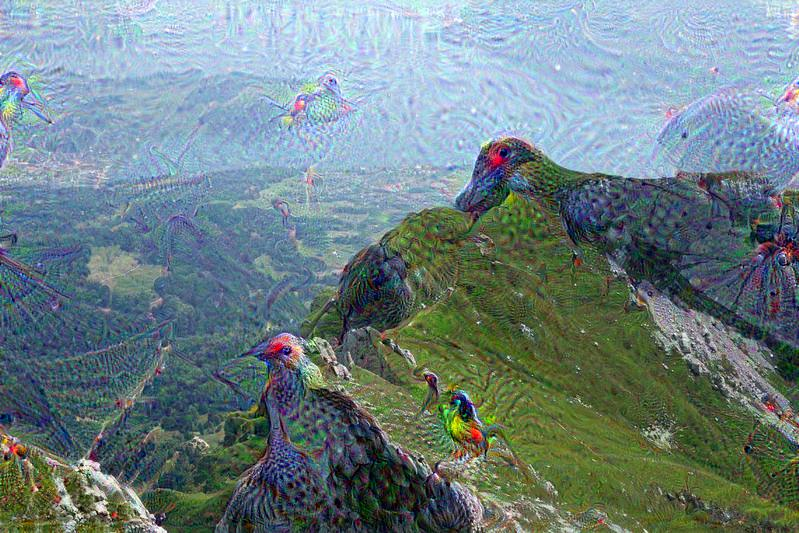

In [0]:
octave_n = 4 #@param {type:"slider", max: 10}
octave_scale = 1.4 #@param {type:"number"}
iter_n = 10 #@param {type:"slider", max: 50}
strength = 200 #@param {type:"slider", max: 1000}
layer = "mixed5a"  #@param ["mixed3a", "mixed3b", "mixed4a", "mixed4c", "mixed5a"]

# DeepDream voláme na niektorú vstvu pre konkrétny obrázok
final = render_deepdream(tf.square(T(layer)), img0)


### 5) Jednotlivé neuróny

Môžeme taktiež vyskúšať DeepDream na jednotlivé neuróny:

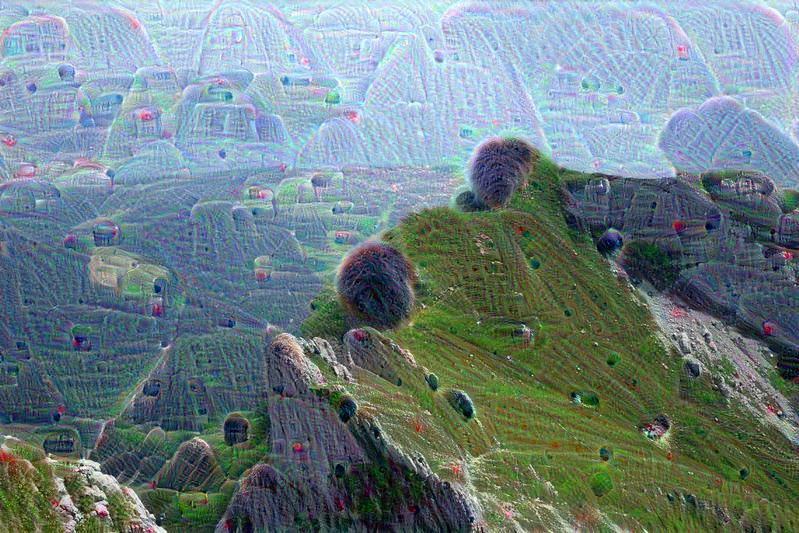

In [0]:
feature_channel = 78 #@param {type:"slider", max: 512}
layer = "mixed4d_3x3_bottleneck_pre_relu"  #@param ["mixed4d_3x3_bottleneck_pre_relu", "mixed3a", "mixed3b", "mixed4a", "mixed4c", "mixed5a"]
if feature_channel >= T(layer).shape[3]:
  print("Zvoleý kanál v danej vrstve ", layer, " neexistuje. ")
  print("Zvolte číslo do {}".format(T(layer).shape[3]))
else:
  render_deepdream(T(layer)[:,:,:,feature_channel], img0)

### 6) Iteratívny DeepDream so zoomom

Ak DeepDream iteratívne spúštame na ten istý obrázok, ale použijeme pritom zoom, tak sa dokážeme dostať k zaujímavo vyzerajúcim obrázkom.

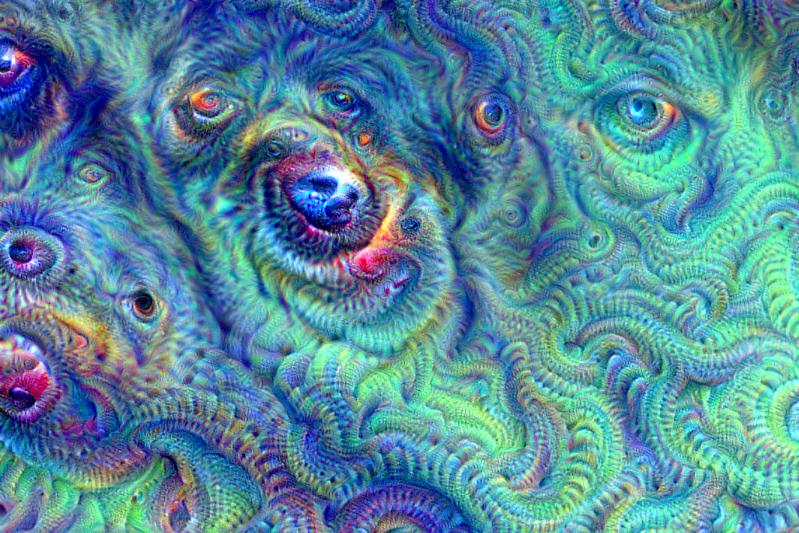

In [0]:
hmlayer = "mixed4d_3x3_bottleneck_pre_relu" #@param ["mixed4d_3x3_bottleneck_pre_relu", "mixed3a", "mixed3b", "mixed4a", "mixed4c", "mixed5a"]
iter_n = 5 #@param {type:"slider", max: 50}
strength = 279 #@param {type:"slider", max: 1000}
zooming_steps = 20 #@param {type:"slider", max: 512}
zoom_factor = 1.5 #@param {type:"number"}

frame = img0
img_y, img_x, _ = img0.shape
for i in range(zooming_steps):
  frame = render_deepdream(tf.square(T(layer)), frame, False)
  clear_output()
  showarray(frame)
  newsize = np.int32(np.float32(frame.shape[:2])*zoom_factor)
  frame = resize(frame, newsize)
  frame = frame[(newsize[0]-img_y)//2:(newsize[0]-img_y)//2+img_y,
                (newsize[1]-img_x)//2:(newsize[1]-img_x)//2+img_x,:]
  

## 7) Ďalšie vrstvy modelu Inception

Teraz si môžeme pozrieť všetky vrstvy modelu neurónovej siete

In [0]:
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print('Počet vrstiev', len(layers))
print('Celkový počet kanálov:', sum(feature_nums))

for layer in layers:
  print('Vrstva:', layer)

Počet vrstiev 59
Celkový počet kanálov: 7548
Vrstva: import/conv2d0_pre_relu/conv
Vrstva: import/conv2d1_pre_relu/conv
Vrstva: import/conv2d2_pre_relu/conv
Vrstva: import/mixed3a_1x1_pre_relu/conv
Vrstva: import/mixed3a_3x3_bottleneck_pre_relu/conv
Vrstva: import/mixed3a_3x3_pre_relu/conv
Vrstva: import/mixed3a_5x5_bottleneck_pre_relu/conv
Vrstva: import/mixed3a_5x5_pre_relu/conv
Vrstva: import/mixed3a_pool_reduce_pre_relu/conv
Vrstva: import/mixed3b_1x1_pre_relu/conv
Vrstva: import/mixed3b_3x3_bottleneck_pre_relu/conv
Vrstva: import/mixed3b_3x3_pre_relu/conv
Vrstva: import/mixed3b_5x5_bottleneck_pre_relu/conv
Vrstva: import/mixed3b_5x5_pre_relu/conv
Vrstva: import/mixed3b_pool_reduce_pre_relu/conv
Vrstva: import/mixed4a_1x1_pre_relu/conv
Vrstva: import/mixed4a_3x3_bottleneck_pre_relu/conv
Vrstva: import/mixed4a_3x3_pre_relu/conv
Vrstva: import/mixed4a_5x5_bottleneck_pre_relu/conv
Vrstva: import/mixed4a_5x5_pre_relu/conv
Vrstva: import/mixed4a_pool_reduce_pre_relu/conv
Vrstva: import/m

Môžeme si vyskúšat DeepDream na konkrétnej vrstve. Tu musíte prepísať názov.

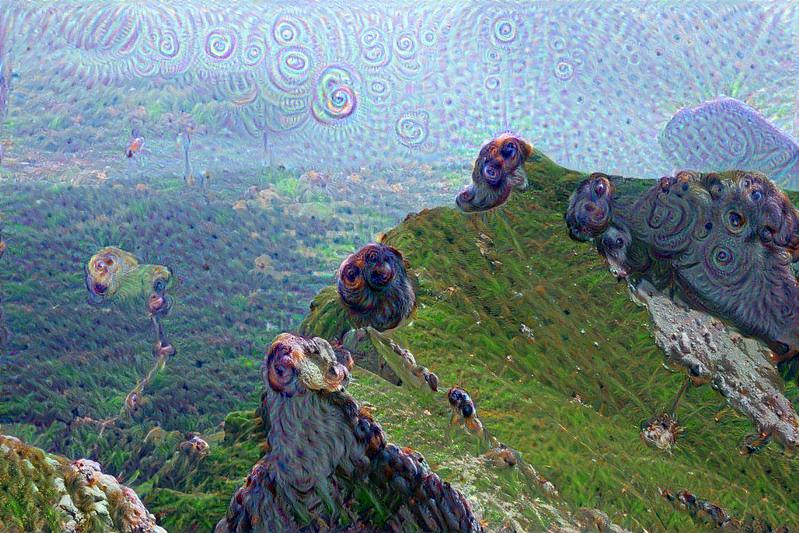

In [0]:
layer = "mixed4a_3x3_pre_relu"
final = render_deepdream(tf.square(T(layer)), img0)

Vrstvy si môžeme zobraziť aj na peknom diagrame aby sme vedeli aké majú vzťahy.

In [0]:
from IPython.display import  HTML
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Zobraziť TF graf."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Zobrazenie výpočtového grafu. Na niektoré vrstvy je možné kliknúť a zobraziť 
# tak ich vnútornú štruktúru.
tmp_def = rename_nodes(graph_def, lambda s:"/".join(s.split('_',1)))
show_graph(tmp_def)